# Setup
Import and confict modules

In [1]:
! pip install gdown

import gdown

In [2]:
import os
import tensorflow as tf
import tensorflow_hub as hub
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
def download_from_gdrive_url(share_url, output_file, cache_dir=None):
    if cache_dir:
        os.makedirs('./images', exist_ok=True)
        output = f"{cache_dir}/{output_file}"
    else:
        output = output_file

    gdown.download(share_url, output, quiet=False, fuzzy=True)
    return output

content_url = 'https://drive.google.com/file/d/1Viw0B2-IYvCuFvdGdSr5VKP_gxK4IO0R/view?usp=sharing'
style_url = 'https://drive.google.com/file/d/1VbkJmgMnKTFGjjnsTn9IfoRc-J9b0RQI/view?usp=sharing'


In [6]:
content_path = download_from_gdrive_url(content_url,'content_image.jpeg', cache_dir='./images')
style_path = download_from_gdrive_url(style_url,'style_image.jpeg', cache_dir='./images')

Downloading...
From: https://drive.google.com/uc?id=1Viw0B2-IYvCuFvdGdSr5VKP_gxK4IO0R
To: /content/images/content_image.jpeg
100%|██████████| 1.16M/1.16M [00:00<00:00, 37.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VbkJmgMnKTFGjjnsTn9IfoRc-J9b0RQI
To: /content/images/style_image.jpeg
100%|██████████| 541k/541k [00:00<00:00, 64.3MB/s]


# Visualize the input
Define a function to load an image and limit its maximum dimension to 512 pixels.

In [7]:
## Load image
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [8]:
## Show image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

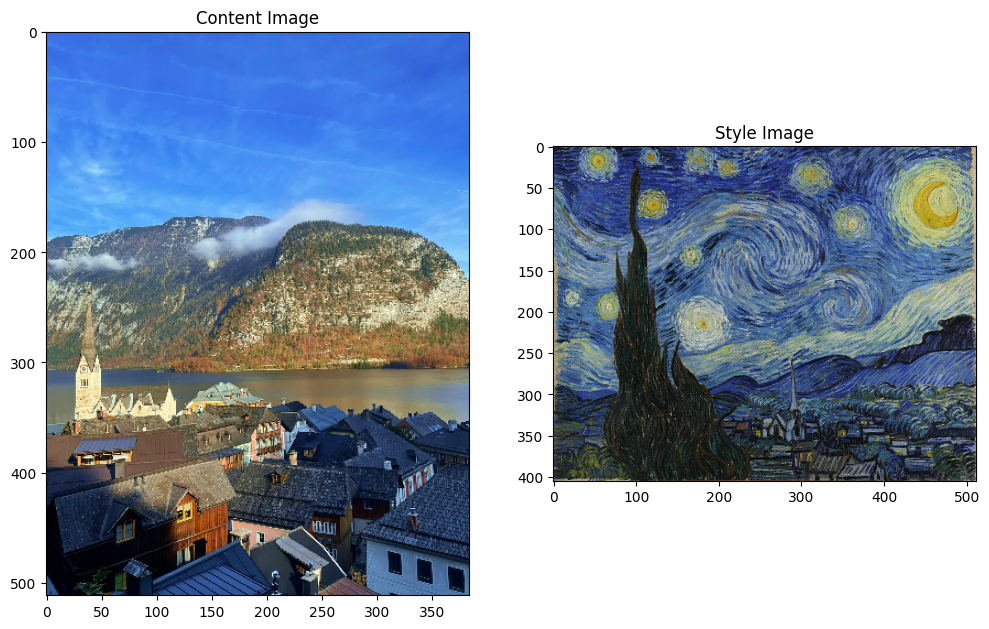

In [9]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Fast Style Transfer using TF-Hub


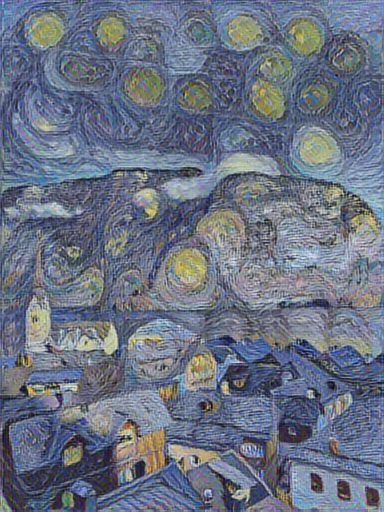

In [10]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# Define content and style representations

In [15]:
x = tf.keras.applications.vgg16.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [16]:
predicted_top_5 = tf.keras.applications.vgg16.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('alp', np.float32(0.2720465)),
 ('dome', np.float32(0.11019518)),
 ('tile_roof', np.float32(0.10346737)),
 ('monastery', np.float32(0.08365095)),
 ('patio', np.float32(0.05928324))]

In [17]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [18]:
content_layers = ['block4_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Build the model

In [19]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [20]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_84']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)


block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  643.81067
  mean:  23.411499

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  3844.6497
  mean:  229.515

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  10637.814
  mean:  300.3538

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  9387.843
  mean:  167.07309



# Calculate the style

In [21]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# Extract style and content

In [22]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [23]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_103']
Received: inputs=Tensor(shape=(1, 512, 384, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.017067801
    max:  31530.547
    mean:  1327.8365

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  343499.94
    mean:  49241.336

   block3_conv1
    shape:  (1, 256, 256)
    min:  64.600426
    max:  1096819.5
    mean:  73929.36

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  774943.7
    mean:  25131.627

Contents:
   block4_conv2
    shape:  (1, 64, 48, 512)
    min:  0.0
    max:  4077.8682
    mean:  81.33065


# Run gradient descent

In [24]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Define a tf.Variable to contain the image to optimize.
# To make this quick, initialize it with the content image (the tf.Variable must be the same shape as the content image)
image = tf.Variable(content_image)

# Since this is a float image, define a function to keep the pixel values between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Create an optimizer. The paper recommends LBFGS, but Adam works okay, too
opt = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.99, epsilon=1e-1)

# To optimize this, use a weighted combination of the two losses to get the total loss
style_weight = 1
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_103']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)


In [26]:
total_variation_weight=50

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Train a few step to see initial results

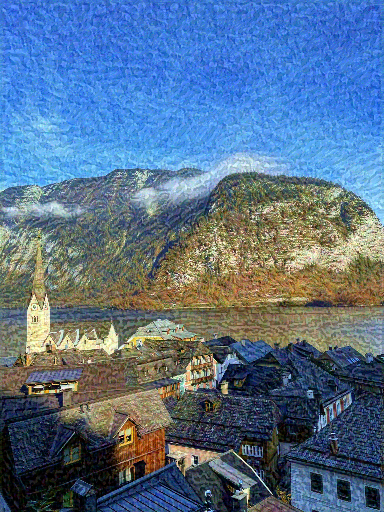

In [27]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

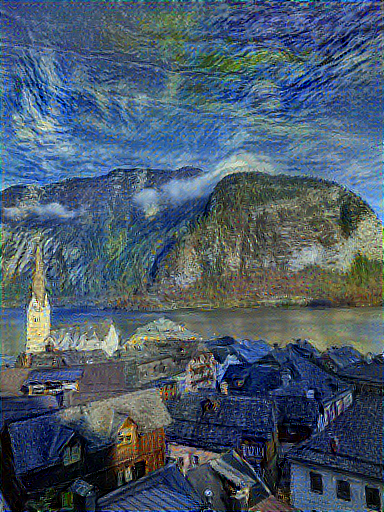

Train step: 500
Total time: 2454.1


In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

import time
start = time.time()

epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))